In [2]:
from google.colab import drive
drive.mount('/content/drive')


import os
os.chdir('/content/drive/MyDrive/BT4222/')
from sklearn.preprocessing import LabelEncoder
import pandas as pd

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pyarrow.parquet as pq
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from sklearn.model_selection import train_test_split
from collections import Counter
from gensim.models.fasttext import load_facebook_vectors  # For using embeddings only



nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('danish'))
lemmatizer = WordNetLemmatizer()
model = load_facebook_vectors('cc.da.300.bin')
dataset_type = "ebnerd_demo"
base_path = os.path.join(".", dataset_type)

text_column = 'title'
articles_columns = ["article_id", "title"]
all_articles = pd.read_parquet('articles.parquet')[articles_columns]


cols_hist = ['user_id', 'article_id_fixed']

history_articles_train = pd.read_parquet('train/history.parquet')[cols_hist]
history_articles_val = pd.read_parquet('validation/history.parquet')[cols_hist]
history_articles_train.rename(columns={'article_id_fixed' : 'article_id'}, inplace=True)
history_articles_val.rename(columns={'article_id_fixed': 'article_id'}, inplace=True)
history_articles = pd.concat([history_articles_train, history_articles_val], ignore_index=True)


def preprocess_behaviors(behaviors_ds):
    selected_columns = ['impression_id', 'article_id', 'user_id', 'is_sso_user', 'is_subscriber', 'age', 'gender', 'device_type']
    filtered_data = behaviors_ds[selected_columns]

    # Convert columns to numerical values
    filtered_data['article_id'] = pd.to_numeric(filtered_data['article_id'].fillna(0), downcast='integer')
    filtered_data['age'] = pd.to_numeric(filtered_data['age'].fillna(0), downcast='integer')
    filtered_data['gender'] = pd.to_numeric(filtered_data['gender'].fillna(-1), downcast='integer')

    # One-hot encoding for device_type and gender
    device_one_hot = pd.get_dummies(filtered_data['device_type'], prefix='device_type')
    filtered_data = pd.concat([filtered_data, device_one_hot], axis=1).drop(columns=['device_type'])

    gender_one_hot = pd.get_dummies(filtered_data['gender'], prefix='gender')
    filtered_data = pd.concat([filtered_data, gender_one_hot], axis=1).drop(columns=['gender'])

    # Convert boolean columns to integers
    filtered_data['is_sso_user'] = filtered_data['is_sso_user'].astype(int)
    filtered_data['is_subscriber'] = filtered_data['is_subscriber'].astype(int)

    return filtered_data


# Define an Embedding Model in PyTorch
class ImpressionEmbeddingModel(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(ImpressionEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

# Custom Dataset for impression IDs
class ImpressionDataset(Dataset):
    def __init__(self, impression_ids):
        self.impression_ids = impression_ids

    def __len__(self):
        return len(self.impression_ids)

    def __getitem__(self, idx):
        return torch.tensor(self.impression_ids[idx], dtype=torch.long)

# Function to create embeddings
def create_impression_embeddings_df(filtered_data, embedding_dim=8, batch_size=512):
    # Step 1: Create a mapping for impression_id to continuous indices
    unique_impressions = filtered_data[['impression_id', 'user_id']].drop_duplicates()
    unique_impressions.reset_index(drop=True, inplace=True)
    impression_mapping = {orig_id: new_id for new_id, orig_id in enumerate(unique_impressions['impression_id'])}

    # Map impression IDs in filtered_data
    filtered_data['mapped_impression_id'] = filtered_data['impression_id'].map(impression_mapping)

    # Define model
    input_dim = len(impression_mapping)  # Number of unique impressions
    model = ImpressionEmbeddingModel(input_dim=input_dim, embedding_dim=embedding_dim)
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()  # Set model to evaluation mode

    # Create Dataset and DataLoader for batch processing
    impression_dataset = ImpressionDataset(impression_ids=list(impression_mapping.values()))
    impression_loader = DataLoader(impression_dataset, batch_size=batch_size, shuffle=False)

    # Collect embeddings
    embeddings_list = []
    with torch.no_grad():
        for batch in impression_loader:
            batch = batch.to('cuda' if torch.cuda.is_available() else 'cpu')
            embeddings = model(batch)
            embeddings_list.extend(embeddings.cpu().numpy())  # Move to CPU for storing in a list

    # Step 3: Create a DataFrame with the original impression IDs and embeddings
    embeddings_df = pd.DataFrame({
        'impression_id': unique_impressions['impression_id'],
        'user_id': unique_impressions['user_id'],
        'user_embeddings': [embedding.tolist() for embedding in embeddings_list]
    })

    return embeddings_df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [4]:

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def clean_and_tokenize(title):
    # Remove punctuation from title
    title_cleaned = title.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(title_cleaned.lower())
    words_lemmatized = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words]
    return [w for w in words_lemmatized if not w in stop_words]



from collections import Counter
def build_vocabs(titles):
  all_words = [word for title in titles for word in title]
  word_count = Counter(all_words)
  vocabulary = {word: idx + 1 for idx, (word, count) in enumerate(word_count.items())}
  vocabulary['<UNK>'] = 0
  return vocabulary




def get_embedding_sequence(title, model):
    embedding_sequence = []
    for word in title:  # Assuming 'title' is a list of words
        if word in model:  # Check if the word is in the model
            embedding_sequence.append(model[word])
        else:
            embedding_sequence.append(np.zeros(model.vector_size))  # Zero vector for unknown words

    if len(embedding_sequence) == 0:
        print("Entirely empty sequence, creating a fully empty sequence")
        # Entirely empty sequence, create a single zero vector (or empty array if desired)
        embedding_sequence = np.zeros((1, model.vector_size))
    else:
        embedding_sequence = np.array(embedding_sequence)

    print("Embedding sequence shape:", embedding_sequence.shape)
    return embedding_sequence




vocabulary = build_vocabs(all_articles[text_column])  #vocabulary 15432
all_articles[text_column] = all_articles[text_column].apply(clean_and_tokenize)
# Apply the function to each row in the DataFrame to create sequences
all_articles['title_embedding_sequence'] = all_articles['title'].apply(lambda x: get_embedding_sequence(x, model))
articles_embeddings_dict = dict(zip(all_articles['article_id'], all_articles['title_embedding_sequence']))




filePath_with_all_features = r"/content/drive/MyDrive/BT4222/xgboost_dataset_ebnerd_demo.parquet"
data = pd.read_parquet(filePath_with_all_features)
print(data.columns.values)


# Load the original behavior data
original_behaviors_train = pd.read_parquet(r"/content/drive/MyDrive/BT4222/train/behaviors.parquet")
original_behaviors_valid = pd.read_parquet(r"/content/drive/MyDrive/BT4222/validation/behaviors.parquet")

# Preprocess behaviors data
preprocessed_behaviors_train = preprocess_behaviors(original_behaviors_train)
preprocessed_behaviors_valid = preprocess_behaviors(original_behaviors_valid)

# Define the embedding dimension
embedding_dim = 8

# Generate impression embeddings for the training and validation datasets
embeddings_df_train = create_impression_embeddings_df(preprocessed_behaviors_train, embedding_dim)
embeddings_df_valid = create_impression_embeddings_df(preprocessed_behaviors_valid, embedding_dim)

# Concatenate training and validation embeddings into one DataFrame
embeddings_user = pd.concat([embeddings_df_train, embeddings_df_valid], axis=0).reset_index(drop=True)

# Now `embeddings_user` contains both training and validation impression embeddings
print(embeddings_user.head())

data.reset_index(drop=True, inplace=True)
embeddings_user.reset_index(drop=True, inplace=True)

impression_user_data_cols = ['impression_id', 'user_embeddings', 'user_id']
candidate_news_data_cols = ['impression_id', 'article_id', 'clicked','user_id']
candidate_news_data = data[candidate_news_data_cols]
data = pd.merge(candidate_news_data, embeddings_user, on=['impression_id','user_id'])
data['clicked'] = data['clicked'].astype(int)

impression_ids = data['impression_id'].unique()

# Convert columns to numeric, coercing errors to NaN
data['impression_id'] = pd.to_numeric(data['impression_id'], errors='coerce')
data['article_id'] = pd.to_numeric(data['article_id'], errors='coerce')
data['clicked'] = pd.to_numeric(data['clicked'], errors='coerce')
data['user_id'] = pd.to_numeric(data['user_id'], errors='coerce')

# Drop rows with NaN values (which were non-numeric initially)
data.dropna(inplace=True)

# Convert to integers if needed
data['impression_id'] = data['impression_id'].astype(int)
data['article_id'] =data['article_id'].astype(int)
data['clicked'] = data['clicked'].astype(int)
data['user_id'] = data['user_id'].astype(int)

# Verify data types and output a sample
print(data.dtypes)
print(data.head())

# Split impression IDs into training and temporary sets (temporary will be split into validation and test)
train_ids, temp_ids = train_test_split(impression_ids, test_size=0.4, random_state=42)  # 60% train, 40% temp
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)  # Split temp into 20% val, 20% test
# Split the actual data based on IDs
data.reset_index(inplace=True)
train_data = data[data['impression_id'].isin(train_ids)]
val_data = data[data['impression_id'].isin(val_ids)]
test_data = data[data['impression_id'].isin(test_ids)]
history_articles.rename(columns={'article_id' : 'clicked_article_ids'},inplace=True)
impression_user_data_train, candidate_news_data_train = train_data[impression_user_data_cols], train_data[candidate_news_data_cols]
impression_user_data_val, candidate_news_data_val = val_data[impression_user_data_cols], val_data[candidate_news_data_cols]
impression_user_data_test, candidate_news_data_test = test_data[impression_user_data_cols], test_data[candidate_news_data_cols]





[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Embedding sequence shape: (3, 300)
Embedding sequence shape: (5, 300)
Embedding sequence shape: (6, 300)
Embedding sequence shape: (6, 300)
Embedding sequence shape: (3, 300)
Embedding sequence shape: (3, 300)
Embedding sequence shape: (5, 300)
Embedding sequence shape: (5, 300)
Embedding sequence shape: (6, 300)
Embedding sequence shape: (6, 300)
Embedding sequence shape: (8, 300)
Embedding sequence shape: (7, 300)
Embedding sequence shape: (5, 300)
Embedding sequence shape: (6, 300)
Embedding sequence shape: (4, 300)
Embedding sequence shape: (4, 300)
Embedding sequence shape: (5, 300)
Embedding sequence shape: (3, 300)
Embedding sequence shape: (4, 300)
Embedding sequence shape: (4, 300)
Embedding sequence shape: (2, 300)
Embedding sequence shape: (4, 300)
Embedding sequence shape: (6, 300)
Embedding sequence shape: (4, 300)
Embedding sequence shape: (4, 300)
Embedding sequence shape: (3, 300)
Embedding sequence shape:

<ipython-input-3-4a0ce3e75301>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['article_id'] = pd.to_numeric(filtered_data['article_id'].fillna(0), downcast='integer')
<ipython-input-3-4a0ce3e75301>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['age'] = pd.to_numeric(filtered_data['age'].fillna(0), downcast='integer')
<ipython-input-3-4a0ce3e75301>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

   impression_id  user_id                                    user_embeddings
0          48401    22779  [1.2212798595428467, 0.6943372488021851, 0.200...
1         152513   150224  [-0.7197679281234741, -0.9038483500480652, -0....
2         155390   160892  [0.49390122294425964, -0.7661394476890564, 1.2...
3         214679  1001055  [0.1251937299966812, 0.9545615911483765, 0.236...
4         214681  1001055  [0.37731826305389404, -0.2389950156211853, -1....
impression_id       int64
article_id          int64
clicked             int64
user_id             int64
user_embeddings    object
dtype: object
   impression_id  article_id  clicked  user_id  \
0          48401     9774516        0    22779   
1          48401     9771051        0    22779   
2          48401     9770028        0    22779   
3          48401     9775402        0    22779   
4          48401     9774461        0    22779   

                                     user_embeddings  
0  [1.2212798595428467, 0.694337248802

DATASET

In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset
import random

import numpy as np
import torch
from torch.utils.data import Dataset
import random

class NPA_Dataset(Dataset):
    def __init__(self, historical_clicks, impression_user_data, candidate_news_data, article_embedding_dict, k_negatives=5, embedding_dim=300, train=True):
        super(NPA_Dataset, self).__init__()
        self.impression_user_data = impression_user_data.set_index('impression_id', drop=False)
        self.candidate_news_data = candidate_news_data.set_index('impression_id', drop=False)
        self.historical_clicks = historical_clicks
        self.article_embedding_dict = article_embedding_dict
        self.default_embedding = np.zeros(embedding_dim)
        self.embedding_dim = embedding_dim
        self.k_negatives = k_negatives
        self.all_news_ids = list(article_embedding_dict.keys())  # List of all news article IDs
        self.train = train  # Training mode (with negative sampling) vs. evaluation mode

    def __len__(self):
        return len(self.impression_user_data)

    def get_negative_samples(self, positive_article_ids):
        # Sample K negative articles that are not in positive_article_ids
        negative_samples = random.sample([news_id for news_id in self.all_news_ids if news_id not in positive_article_ids], self.k_negatives)
        return negative_samples

    def __getitem__(self, idx):
        # Retrieve information for the current impression
        impression_info = self.impression_user_data.iloc[idx]
        impression_id = impression_info.name  # impression_id
        user_id = impression_info['user_id']

        # User features
        user_features = torch.tensor(impression_info['user_embeddings'], dtype=torch.float32)

        # Retrieve candidate news articles for the impression
        candidate_articles = self.candidate_news_data.loc[impression_id]
        positive_article_ids = candidate_articles[candidate_articles['clicked'] == 1]['article_id'].tolist()
        candidate_article_ids = candidate_articles['article_id'].tolist()

        if self.train:
            # **Training Mode**: Use negative sampling (k+1 candidates)
            if len(positive_article_ids) == 0:
                return None  # Skip cases without any clicked article

            # Choose one clicked article as the positive sample
            positive_article_id = positive_article_ids[0]
            positive_embedding = torch.tensor(self.article_embedding_dict.get(positive_article_id, self.default_embedding), dtype=torch.float32)

            # Sample `k_negatives` negatives
            negative_article_ids = self.get_negative_samples(positive_article_ids)
            negative_embeddings = [torch.tensor(self.article_embedding_dict.get(article_id, self.default_embedding), dtype=torch.float32) for article_id in negative_article_ids]

            # Create the candidate news embeddings with 1 positive and `k` negatives
            candidate_news_embeddings = [positive_embedding] + negative_embeddings
            labels = torch.zeros(self.k_negatives + 1, dtype=torch.float32)
            labels[0] = 1  # Label positive sample as 1, negatives as 0

        else:
            # **Evaluation Mode**: Use all candidate articles for a full ranking
            candidate_news_embeddings = [torch.tensor(self.article_embedding_dict.get(article_id, self.default_embedding), dtype=torch.float32) for article_id in candidate_article_ids]
            labels = torch.tensor(candidate_articles['clicked'].values, dtype=torch.float32)  # True labels for all candidates

        # Historical news embeddings (user's clicked articles)
        historical_article_ids = self.historical_clicks.loc[self.historical_clicks['user_id'] == user_id, 'clicked_article_ids'].iloc[0]
        historical_news_embeddings = [
            torch.tensor(self.article_embedding_dict.get(article_id, self.default_embedding), dtype=torch.float32)
            for article_id in historical_article_ids
        ]

        return (candidate_news_embeddings, historical_news_embeddings, user_features), labels, impression_id



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UserPreferenceQuery(nn.Module):
    def __init__(self, num_filters, query_dim_d, embedding_dim):
        super(UserPreferenceQuery, self).__init__()
        # Ensure query_dim_w matches num_filters from NewsEncoder
        self.Vw = nn.Linear(embedding_dim, num_filters, bias=False)  # Match num_filters
        self.vw = nn.Parameter(torch.zeros(num_filters))  # Learnable parameter for word-level query

        # Document-level query dimension should match query_dim_d expected in UserEncoder
        self.Vd = nn.Linear(embedding_dim, query_dim_d, bias=False)
        self.vd = nn.Parameter(torch.zeros(query_dim_d))  # Learnable parameter for document-level query

    def forward(self, user_embedding):
        # Project user embedding to obtain word and document queries
        qd = F.relu(self.Vd(user_embedding) + self.vd)  # Document-level query
        qw = F.relu(self.Vw(user_embedding) + self.vw)  # Word-level query
        return qw, qd



class NewsEncoder(nn.Module):
    def __init__(self, num_filters, filter_size, embedding_dim, query_dim):
        super(NewsEncoder, self).__init__()
        self.conv = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=filter_size, padding='same')
        self.query_projection = nn.Linear(query_dim, num_filters)  # Project `qw` to match `num_filters`
        self.score_projection = nn.Linear(num_filters, 1, bias=False)  # Projection layer for attention scoring
        self.num_filters =num_filters

    def forward(self, inputs, query_vector, mask=None):
        batch_size, num_articles, seq_len, embedding_dim = inputs.shape

        # Reshape inputs for Conv1d: [batch_size * num_articles, embedding_dim, seq_len]
        inputs = inputs.view(batch_size * num_articles, embedding_dim, seq_len)

        # Apply Conv1d and activation
        x = F.relu(self.conv(inputs))  # Shape: [batch_size * num_articles, num_filters, seq_len]
        x = x.transpose(1, 2)  # Shape: [batch_size * num_articles, seq_len, num_filters]

        # Adjust `query_vector` shape to match number of articles
        query_vector_projected = self.query_projection(query_vector)
        query_vector_projected = query_vector_projected.view(batch_size, 1, self.num_filters).expand(batch_size, num_articles, self.num_filters)
        query_vector_projected = query_vector_projected.reshape(batch_size * num_articles, 1, self.num_filters)

        # Calculate attention scores
        attention_input = torch.tanh(x + query_vector_projected)  # Shape: [batch_size * num_articles, seq_len, num_filters]
        attention_scores = torch.softmax(self.score_projection(attention_input), dim=1)

        # Apply mask if provided
        if mask is not None:
            try:
                # Reshape `mask` to [batch_size * num_articles, seq_len, 1]
                mask = mask.view(batch_size * num_articles, seq_len, 1)
                attention_scores = attention_scores * mask
                attention_scores = attention_scores / (attention_scores.sum(dim=1, keepdim=True) + 1e-9)
            except RuntimeError as e:
                print(f"Mask shape mismatch: {mask.shape}. Expected [{batch_size * num_articles}, {seq_len}, 1].")
                raise e

        # Compute context vector as a weighted sum
        context_vector = torch.sum(x * attention_scores, dim=1)  # Shape: [batch_size * num_articles, num_filters]
        context_vector = context_vector.view(batch_size, num_articles, -1)

        return context_vector


class UserEncoder(nn.Module):
    def __init__(self, query_dim_d, num_filters):
        super(UserEncoder, self).__init__()
        self.query_projection = nn.Linear(query_dim_d, num_filters, bias=False)  # Project `qd` to match `num_filters`

    def forward(self, news_encoder_outputs, query_vector, mask=None):
        batch_size, num_clicked_news, num_filters = news_encoder_outputs.shape

        # Project `query_vector` (`qd`) to match `num_filters`
        query_vector_projected = self.query_projection(query_vector)  # Shape: [batch_size, num_filters]

        # Expand `query_vector_projected` across `num_clicked_news` to match `news_encoder_outputs`
        query_vector_expanded = query_vector_projected.unsqueeze(1).expand(batch_size, num_clicked_news, num_filters)  # Shape: [batch_size, num_clicked_news, num_filters]

        # Calculate attention scores
        scores = torch.tanh(news_encoder_outputs + query_vector_expanded).sum(dim=-1)  # Shape: [batch_size, num_clicked_news]
        attention_scores = torch.softmax(scores, dim=1)  # Softmax over clicked news items

        # Apply mask at the article level
        if mask is not None:
            # Ensure mask has correct shape: [batch_size, num_clicked_news]
            mask = mask.any(dim=-1)  # Aggregate mask across the word sequence to get article-level mask
            attention_scores = attention_scores * mask
            attention_scores = attention_scores / (attention_scores.sum(dim=1, keepdim=True) + 1e-9)  # Re-normalize

        # Weighted sum to get user profile vector
        user_profile_vector = torch.sum(attention_scores.unsqueeze(-1) * news_encoder_outputs, dim=1)  # Shape: [batch_size, num_filters]

        return user_profile_vector



class ClickPredictor(nn.Module):
    def forward(self, candidate_news_vectors, user_vector, mask=None):
        user_vector = user_vector.squeeze(1)  # Shape: [batch_size, num_filters]
        user_vector_expanded = user_vector.unsqueeze(1).expand_as(candidate_news_vectors)  # Shape: [batch_size, num_candidates, num_filters]
        logits = torch.sum(candidate_news_vectors * user_vector_expanded, dim=-1)  # Shape: [batch_size, num_candidates]

        if mask is not None:
            mask = mask.any(dim=-1)
            logits = logits.masked_fill(~mask, float('-inf'))

        return logits  # Return raw logits





class NPA_Model(nn.Module):
    def __init__(self, num_filters, filter_size, query_dim_w=8, query_dim_d=8, embeddings_user_dim=8, embeddings_news_dim=300):
        super(NPA_Model, self).__init__()
        self.user_preference_query = UserPreferenceQuery(query_dim_w, query_dim_d, embeddings_user_dim)
        self.news_encoder = NewsEncoder(num_filters=num_filters, filter_size=filter_size, embedding_dim=embeddings_news_dim, query_dim=8)
        self.user_encoder = UserEncoder(query_dim_d, num_filters)
        self.click_predictor = ClickPredictor()

    def forward(self, candidate_news, clicked_news, user_embeddings, candidate_mask=None, clicked_mask=None):
        qw, qd = self.user_preference_query(user_embeddings)
        candidate_news_vectors = self.news_encoder(candidate_news, qw, mask=candidate_mask)
        clicked_news_vectors = self.news_encoder(clicked_news, qw, mask=clicked_mask)
        user_profile_vector = self.user_encoder(clicked_news_vectors, qd, mask=clicked_mask)
        logits = self.click_predictor(candidate_news_vectors, user_profile_vector, mask=candidate_mask)

        probabilities = F.softmax(logits, dim=1)  # Apply softmax over logits for K+1 classification
        return probabilities




In [7]:
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    candidate_news_embeddings, historical_news_embeddings = [], []
    user_features, candidate_mask, clicked_mask, labels, impression_ids = [], [], [], [], []

    # Determine max sequence length for candidate and clicked news in the batch
    max_num_candidates = max(len(candidates) for (candidates, _, _), _, _ in batch)
    max_num_clicked = max(len(clicked) for (_, clicked, _), _, _ in batch)
    max_seq_len_candidates = max(len(news) for (candidates, _, _), _, _ in batch for news in candidates)
    max_seq_len_clicked = max(len(news) for (_, clicked, _), _, _ in batch for news in clicked)

    for (candidates, clicked, user), label, impression_id in batch:
        # Pad each candidate and clicked news sequence
        candidates_padded = [F.pad(news, (0, 0, 0, max_seq_len_candidates - news.size(0))) for news in candidates]
        clicked_padded = [F.pad(news, (0, 0, 0, max_seq_len_clicked - news.size(0))) for news in clicked]

        # Stack padded sequences
        candidate_news_embeddings.append(torch.stack(candidates_padded))
        historical_news_embeddings.append(torch.stack(clicked_padded))
        user_features.append(user)

        # Create masks for the original sequence lengths before padding
        candidate_mask.append(torch.ones(len(candidates), max_seq_len_candidates, dtype=torch.bool))
        clicked_mask.append(torch.ones(len(clicked), max_seq_len_clicked, dtype=torch.bool))

        # Collect labels and impression IDs
        labels.append(label)
        impression_ids.append(impression_id)

    # Pad sequences to the max number of candidates and clicks across the batch
    candidate_news_embeddings = pad_sequence(candidate_news_embeddings, batch_first=True, padding_value=0.0)
    historical_news_embeddings = pad_sequence(historical_news_embeddings, batch_first=True, padding_value=0.0)
    candidate_mask = pad_sequence(candidate_mask, batch_first=True, padding_value=0)
    clicked_mask = pad_sequence(clicked_mask, batch_first=True, padding_value=0)

    # Stack user features and pad labels if they are variable-length sequences
    user_features = torch.stack(user_features)
    labels = pad_sequence(labels, batch_first=True, padding_value=0.0)

    return (candidate_news_embeddings, historical_news_embeddings, user_features, candidate_mask, clicked_mask), labels, impression_ids


In [25]:
import tensorflow as tf
import os
from torch.cuda.amp import GradScaler
from torch.utils.data import DataLoader

# Initialize datasets
train_dataset = NPA_Dataset(history_articles, impression_user_data_train, candidate_news_data_train, articles_embeddings_dict, k_negatives=5, train=True)
val_dataset = NPA_Dataset(history_articles, impression_user_data_val, candidate_news_data_val, articles_embeddings_dict, train=False)
test_dataset = NPA_Dataset(history_articles, impression_user_data_test, candidate_news_data_test, articles_embeddings_dict, train=False)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=10,  pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, num_workers=10,  pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, num_workers=10,  pin_memory=True)


# Initialize model
model = NPA_Model(num_filters=32, filter_size=16)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Define loss function and optimizer
optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
scaler = GradScaler()



torch.backends.cudnn.benchmark = True



# Function to calculate nDCG
def ndcg_at_k(y_true, y_pred, k=3):
    _, top_k_indices = torch.topk(y_pred, k, dim=-1)
    top_k_labels = torch.gather(y_true, 1, top_k_indices).squeeze()
    gain = (2 ** top_k_labels - 1).float()
    discounts = torch.log2(torch.arange(k, dtype=torch.float32, device=y_pred.device) + 2)
    dcg = torch.sum(gain / discounts, dim=-1)
    sorted_labels, _ = torch.sort(y_true, descending=True)
    ideal_gain = (2 ** sorted_labels[:, :k] - 1).float()
    idcg = torch.sum(ideal_gain / discounts, dim=-1)
    ndcg = torch.where(idcg == 0, torch.zeros_like(dcg), dcg / idcg)
    return ndcg.mean()


scaler = torch.cuda.amp.GradScaler()  # Initialize GradScaler for mixed precision


# Loss function for K+1 classification (cross-entropy on positive sample index)
def negative_sampling_loss(logits, labels):
    return F.cross_entropy(logits, labels.argmax(dim=1))

# Training function with mixed precision
def train_mixed_precision(model, dataloader, optimizer, device, k=5):
    model.train()
    total_loss = 0
    ndcg_score = 0
    counter_batch = 1

    for batch in dataloader:
        print(f'Starting batch number {counter_batch}')
        counter_batch += 1

        (candidate_news, clicked_news, user_features, candidate_mask, clicked_mask), labels, impression_id = batch
        candidate_news, clicked_news, user_features, candidate_mask, clicked_mask, labels = (
            candidate_news.to(device),
            clicked_news.to(device),
            user_features.to(device),
            candidate_mask.to(device),
            clicked_mask.to(device),
            labels.to(device)
        )

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():  # Mixed precision forward pass
            logits = model(candidate_news, clicked_news, user_features, candidate_mask, clicked_mask)
            loss = negative_sampling_loss(logits, labels)

        total_loss += loss.item()
        print(f"Loss: {loss} total loss: {total_loss}")

        probabilities = F.softmax(logits, dim=1)
        ndcg_score += ndcg_at_k(labels, probabilities, k=k).item()
        print(f"nDCG score: {ndcg_score}")

        # Backward pass with mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    return total_loss / len(dataloader), ndcg_score / len(dataloader)

# Standard training function (without mixed precision)
def train(model, dataloader, optimizer, device, k=3):
    model.train()
    total_loss = 0
    ndcg_score = 0

    for batch in dataloader:
        (candidate_news, clicked_news, user_features, candidate_mask, clicked_mask), labels, impression_id = batch
        candidate_news, clicked_news, user_features, candidate_mask, clicked_mask, labels = (
            candidate_news.to(device),
            clicked_news.to(device),
            user_features.to(device),
            candidate_mask.to(device),
            clicked_mask.to(device),
            labels.to(device)
        )

        optimizer.zero_grad()
        logits = model(candidate_news, clicked_news, user_features, candidate_mask, clicked_mask)
        loss = negative_sampling_loss(logits, labels)

        total_loss += loss.item()
        probabilities = F.softmax(logits, dim=1)
        ndcg_score += ndcg_at_k(labels, probabilities, k=k).item()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader), ndcg_score / len(dataloader)

# Testing function
def test(model, dataloader, device, k=3):
    model.eval()
    total_loss = 0
    ndcg_score = 0
    impression_ids = []
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            (candidate_news, clicked_news, user_features, candidate_mask, clicked_mask), labels, impression_id = batch
            candidate_news = candidate_news.to(device)
            clicked_news = clicked_news.to(device)
            user_features = user_features.to(device)
            candidate_mask = candidate_mask.to(device)
            clicked_mask = clicked_mask.to(device)
            labels = labels.to(device)

            logits = model(candidate_news, clicked_news, user_features, candidate_mask, clicked_mask)
            probabilities = F.softmax(logits, dim=1)

            all_predictions.extend(probabilities.tolist())
            all_labels.extend(labels.tolist())
            impression_ids.extend(impression_id)

            ndcg_score += ndcg_at_k(labels, probabilities, k=k).item()
            loss = F.cross_entropy(logits, labels.argmax(dim=1))
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_ndcg = ndcg_score / len(dataloader)

    results_df = pd.DataFrame({
        'impression_id': impression_ids,
        'predicted_scores': all_predictions,
        'clicked_labels': all_labels
    })

    return avg_loss, avg_ndcg, results_df






/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-25-64f8513c99df>:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-25-64f8513c99df>:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Initialize GradScaler for mixed precision


In [16]:
import torch
import os
import time
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


torch.backends.cudnn.benchmark = True


# Number of epochs and early stopping patience
epochs = 10
patience = 5 # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize to a very high value
patience_counter = 0  # Counts epochs without improvement
# Format the time as needed, e.g., year-month-day_hour-minute
current_time = time.strftime("%Y%m%d_%H%M", time.localtime())
checkpoint_path = f"model_checkpoint_64batch_{current_time}.pth"  # Checkpoint file path

##TRyING MIXED PRECISION TO ccelea=rate trainiing
try:
    for epoch in range(epochs):

        # Training phase
        avg_loss_t, avg_ndcg_t = train_mixed_precision(model, train_loader, optimizer, device)

        # Validation phase
        avg_loss, avg_ndcg, results_df = test(model, val_loader, device, k=3)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss_t:.4f}, Val Loss: {avg_loss:.4f}, Val nDCG@5: {avg_ndcg:.4f}")

        # Check for improvement
        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            patience_counter = 0  # Reset patience counter
            # Save the best model as a checkpoint
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model improved, saving new checkpoint to {checkpoint_path}")
        else:
            patience_counter += 1  # Increment patience counter if no improvement

        # Early stopping if validation loss hasn't improved for 'patience' epochs
        if patience_counter >= patience:
            print("Early stopping triggered. No improvement in validation loss.")
            break

except KeyboardInterrupt:
    print("Training interrupted by user. Saving model checkpoint...")
    torch.save(model.state_dict(), "interrupted_checkpoint.pth")
    print("Checkpoint saved at interrupted_checkpoint.pth")

# Ensure model is saved at the end
final_path = f"final_model_64batch_{current_time}.pth"
torch.save(model.state_dict(), final_path)
print(f"Training complete. Final model saved at {final_path}")


Using device: cuda


'\ntorch.backends.cudnn.benchmark = True\n\n\n# Number of epochs and early stopping patience\nepochs = 10\npatience = 5 # Number of epochs to wait for improvement before stopping\nbest_val_loss = float(\'inf\')  # Initialize to a very high value\npatience_counter = 0  # Counts epochs without improvement\n# Format the time as needed, e.g., year-month-day_hour-minute\ncurrent_time = time.strftime("%Y%m%d_%H%M", time.localtime())\ncheckpoint_path = f"model_checkpoint_64batch_{current_time}.pth"  # Checkpoint file path\n\n##TRyING MIXED PRECISION TO ccelea=rate trainiing\ntry:\n    for epoch in range(epochs):\n\n        # Training phase\n        avg_loss_t, avg_ndcg_t = train_mixed_precision(model, train_loader, optimizer, device)\n\n        # Validation phase\n        avg_loss, avg_ndcg, results_df = test(model, val_loader, device, k=3)\n\n        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss_t:.4f}, Val Loss: {avg_loss:.4f}, Val nDCG@5: {avg_ndcg:.4f}")\n\n        # Check for

In [26]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_auc_score
import pandas as pd


next_paths = ["/content/drive/MyDrive/BT4222/model_checkpoint_64batch_20241112_0749.pth", "/content/drive/MyDrive/BT4222/final_model_64batch_20241112_0501.pth"]



# Load the model checkpoint
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
!cp /content/drive/MyDrive/BT4222/final_model_64batch_20241112_0819.pth /content/
checkpoint_path = "/content/drive/MyDrive/BT4222/final_model_64batch_20241112_0819.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

model.to(device)

# Test the model
test_loss, test_ndcg, test_data = test(model, test_loader, device, k=3)
test_data.to_csv(r"/content/drive/MyDrive/BT4222/test_data.csv")
print(f"Test Loss: {test_loss:.4f}, Test nDCG@5: {test_ndcg:.4f}")

print(test_data.head())



Using device: cuda


<ipython-input-26-28337cf8f823>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Test Loss: 3.1735, Test nDCG@5: 0.2410
   impression_id                                   predicted_scores  \
0         214684  [0.03888285160064697, 0.038882844150066376, 0....   
1         214684  [0.03888285160064697, 0.038882844150066376, 0....   
2         214684  [0.03888285160064697, 0.038882844150066376, 0....   
3         214684  [0.03888285160064697, 0.038882844150066376, 0....   
4         214684  [0.03888285160064697, 0.038882844150066376, 0....   

                                      clicked_labels  
0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  


            AUC  MRR   NDCG@3   NDCG@5  Accuracy
0      0.956522  1.0  0.63093  0.63093       0.0
1      0.956522  1.0  0.63093  0.63093       0.0
2      0.956522  1.0  0.63093  0.63093       0.0
3      0.956522  1.0  0.63093  0.63093       0.0
4      0.956522  1.0  0.63093  0.63093       0.0
...         ...  ...      ...      ...       ...
41009  0.342105  0.5  0.00000  0.00000       0.0
41010  0.342105  0.5  0.00000  0.00000       0.0
41011  0.342105  0.5  0.00000  0.00000       0.0
41012  0.342105  0.5  0.00000  0.00000       0.0
41013  0.342105  0.5  0.00000  0.00000       0.0

[41014 rows x 5 columns]
Mean Scores Across Impressions:
AUC         0.608608
MRR         0.250691
NDCG@3      0.213750
NDCG@5      0.246309
Accuracy    0.128834
dtype: float64


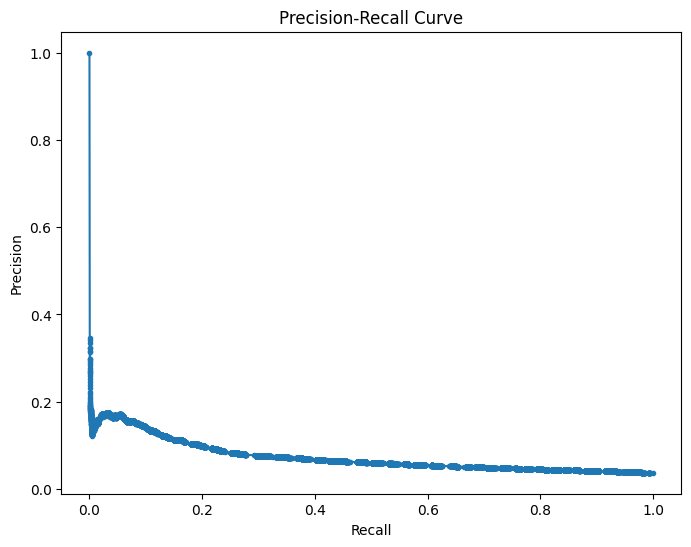

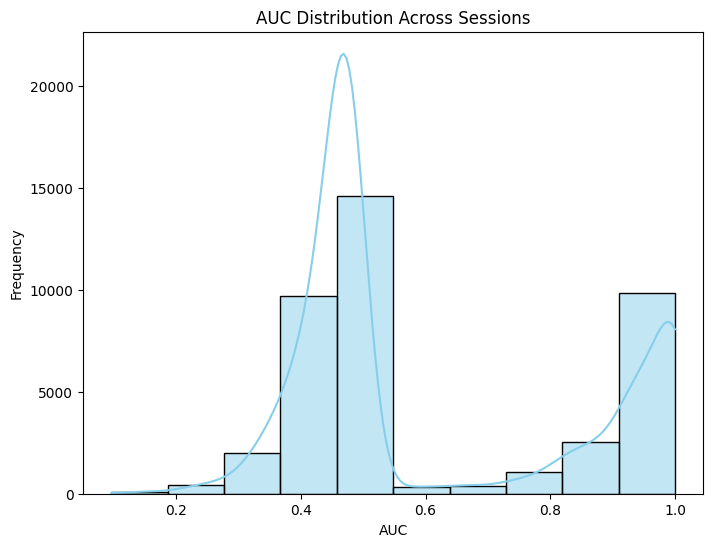

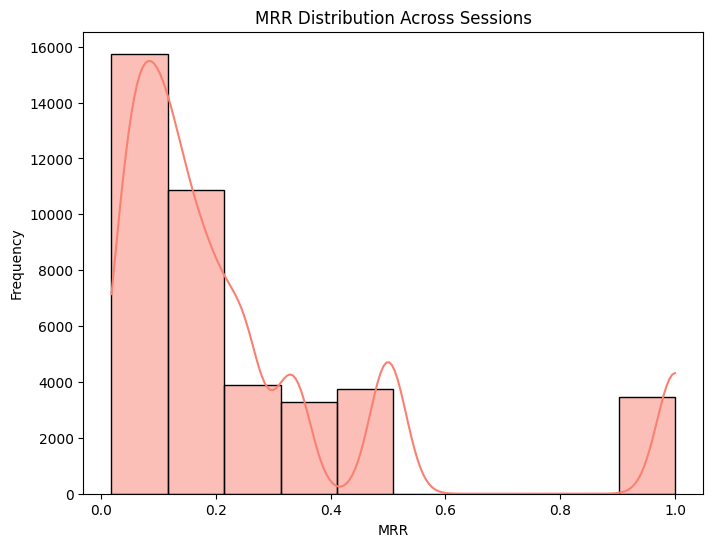

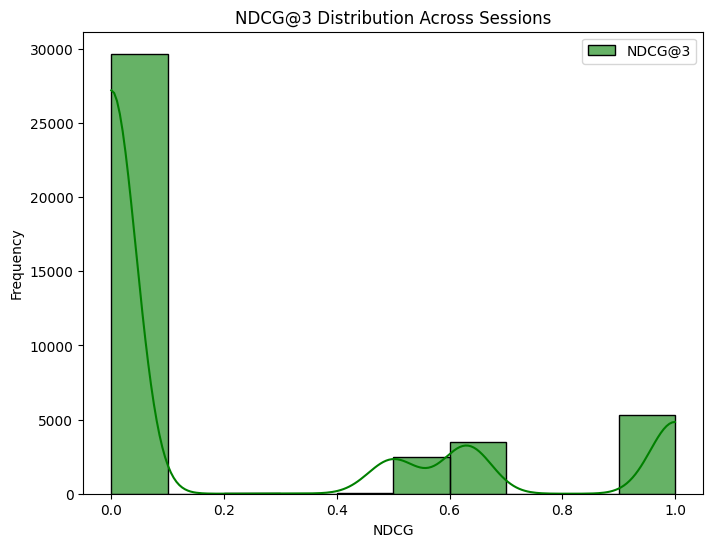

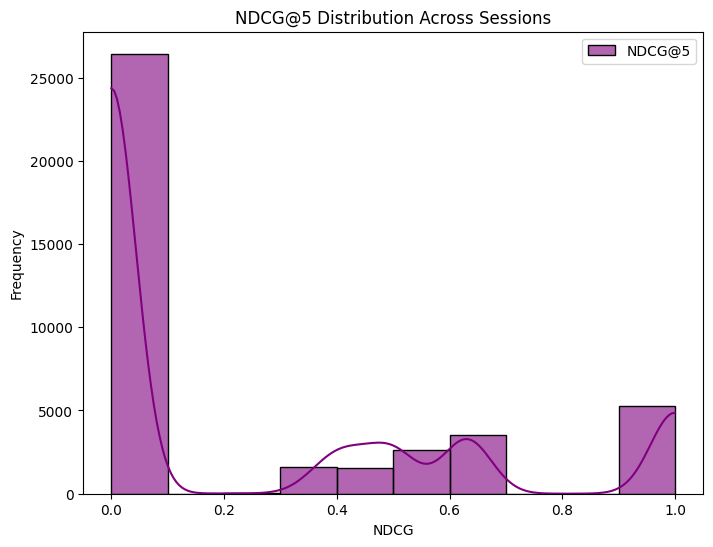

In [29]:
# Metric Calculation Functions
def calculate_auc(predictions, labels):
    return roc_auc_score(labels, predictions)

def calculate_mrr(labels):
    # Find indices where label is 1
    ranks = (pd.Series(labels) == 1).to_numpy().nonzero()[0] + 1
    return 1 / ranks[0] if len(ranks) > 0 else 0

def ndcg_at_k(y_true, y_pred, k=3):
    # Ensure y_true and y_pred are 2D tensors
    if y_true.dim() == 1:
        y_true = y_true.unsqueeze(0)  # Add batch dimension if y_true is 1D
    if y_pred.dim() == 1:
        y_pred = y_pred.unsqueeze(0)  # Add batch dimension if y_pred is 1D

    _, top_k_indices = torch.topk(y_pred, k, dim=-1)
    top_k_labels = torch.gather(y_true, 1, top_k_indices).squeeze()

    gain = (2 ** top_k_labels - 1).float()
    discounts = torch.log2(torch.arange(k, dtype=torch.float32, device=y_pred.device) + 2)
    dcg = torch.sum(gain / discounts, dim=-1)

    sorted_labels, _ = torch.sort(y_true, descending=True)
    ideal_gain = (2 ** sorted_labels[:, :k] - 1).float()
    idcg = torch.sum(ideal_gain / discounts, dim=-1)

    ndcg = torch.where(idcg == 0, torch.zeros_like(dcg), dcg / idcg)
    return ndcg.mean()


def calculate_ndcg(predictions, labels, k):
    y_true = torch.tensor(labels)
    y_pred = torch.tensor(predictions)
    return ndcg_at_k(y_true, y_pred, k=k).item()

def calculate_accuracy(predictions, labels):
    # Find the predicted and actual clicked labels
    pred_clicked = np.argmax(predictions)  # Index of the highest predicted score
    actual_clicked = np.argmax(labels)     # Index of the actual clicked label
    return int(pred_clicked == actual_clicked)  # 1 if correct, 0 otherwise

# Apply metrics to each impression group
results = test_data.apply(lambda row: pd.Series({
    'AUC': calculate_auc(row['predicted_scores'], row['clicked_labels']),
    'MRR': calculate_mrr(row['clicked_labels']),
    'NDCG@3': calculate_ndcg(row['predicted_scores'], row['clicked_labels'], k=3),
    'NDCG@5': calculate_ndcg(row['predicted_scores'], row['clicked_labels'], k=5),
    'Accuracy': calculate_accuracy(row['predicted_scores'], row['clicked_labels'])
}), axis=1)

print(results)


# Calculate and print mean scores across impression IDs
mean_scores = results.mean()
print("Mean Scores Across Impressions:")
print(mean_scores)

# Plotting Functions
def plot_precision_recall(data):
    # Flatten lists for plotting precision-recall
    all_labels = [label for sublist in data['clicked_labels'] for label in sublist]
    all_predictions = [pred for sublist in data['predicted_scores'] for pred in sublist]

    precision, recall, _ = precision_recall_curve(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

# Plot for the whole dataset
plot_precision_recall(test_data)

# AUC Distribution Plot
plt.figure(figsize=(8, 6))
sns.histplot(results['AUC'], kde=True, color="skyblue", bins=10)
plt.title("AUC Distribution Across Sessions")
plt.xlabel("AUC")
plt.ylabel("Frequency")
plt.show()

# MRR Distribution Plot
plt.figure(figsize=(8, 6))
sns.histplot(results['MRR'], kde=True, color="salmon", bins=10)
plt.title("MRR Distribution Across Sessions")
plt.xlabel("MRR")
plt.ylabel("Frequency")
plt.show()

# NDCG@3 Distribution Plot
plt.figure(figsize=(8, 6))
sns.histplot(results['NDCG@3'], kde=True, color="green", label="NDCG@3", bins=10, alpha=0.6)
plt.title("NDCG@3 Distribution Across Sessions")
plt.xlabel("NDCG")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# NDCG@5 Distribution Plot
plt.figure(figsize=(8, 6))
sns.histplot(results['NDCG@5'], kde=True, color="purple", label="NDCG@5", bins=10, alpha=0.6)
plt.title("NDCG@5 Distribution Across Sessions")
plt.xlabel("NDCG")
plt.ylabel("Frequency")
plt.legend()
plt.show()
